Title: **Assignment 2 - COSC3013 Computational Machine Learning - End-to-end Machine Learning Project**

Student ID: **S3979613**

Student Name and email (contact info): **Dao Sy Trung Kien - S3979613@rmit.edu.vn**

Affiliations: **RMIT University Vietnam.**

Date of Report: 03/08/2023

I certify that this is all my own original work. If I took any parts from elsewhere, then they were non-essential parts of the assignment, and they are clearly attributed in my submission.  I will show I agree to this honor code by typing "Yes": Yes.

Please start your report here. 

### Required Libraries and Utilities

In [31]:
# Importing packages - Pandas, Numpy, Seaborn, Scipy, Impute
import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns
import matplotlib.style as style; style.use('fivethirtyeight')
np.random.seed(0)
from sklearn.impute import SimpleImputer

# Modelling
import sklearn.metrics as metrics
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, accuracy_score
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

# Oversampling
from imblearn.over_sampling import SMOTE

# Suppress warnings
import warnings; warnings.filterwarnings('ignore')
pd.options.display.max_rows = 4000

### Import data and check for null values.

In [32]:
# Code for import data from Paitients_Files_Train csv file
df_train = pd.read_csv(r'C:\Users\Kien\Downloads\Computational ML\UCI-electricity\UCI-electricity\UCI_data.csv')
# Print out data.
df_train.head()

,date,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,T5,...,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2,TARGET_energy
0,2016-04-19 20:30:00,22.200000,39.500000,20.566667,37.656667,22.230000,37.030000,22.318571,36.610000,20.633333,...,33.90,9.70,766.100000,65.5,3.500000,40.000000,3.350000,24.061869,24.061869,60
1,2016-03-05 04:40:00,20.356667,37.126667,17.566667,40.230000,20.890000,37.663333,18.700000,36.260000,18.463333,...,41.09,0.30,740.333333,99.0,1.000000,41.333333,0.100000,4.622052,4.622052,50
2,2016-03-14 12:40:00,20.926667,38.790000,21.100000,35.526667,21.600000,36.290000,21.000000,34.826667,18.100000,...,38.76,4.40,768.466667,72.0,6.000000,22.666667,-0.266667,5.635898,5.635898,80
3,2016-01-22 15:30:00,18.290000,38.900000,17.290000,39.260000,18.390000,39.326667,16.100000,38.790000,16.100000,...,39.20,3.35,760.600000,82.0,5.500000,41.000000,0.500000,49.216445,49.216445,40
4,2016-02-10 00:40:00,22.290000,42.333333,21.600000,40.433333,22.666667,43.363333,19.100000,40.900000,19.290000,...,43.73,3.20,738.900000,88.0,7.333333,56.000000,1.400000,47.617579,47.617579,60


In [ ]:
# Calculating the Missing Values % contribution in Train Data
df_train_null = round(100*(df_train.isnull().sum())/len(df_train), 2)
df_train_null

### Basic Data Exploration.

In [ ]:
# Check the dimensions of the Training dataset
print(df_train.shape)

In [ ]:
# Get info of the dataframe columns
df_train.info()

### Data Pre-processing.

In [ ]:
from scipy import stats

# Calculate Z-scores for each column
z_scores = stats.zscore(df_train.select_dtypes(include=[float, int]))

# Create a boolean mask for rows where all Z-scores are less than 3
mask = (abs(z_scores) < 3).all(axis=1)

# Filter the DataFrame using the mask
df_train_filtered = df_train[mask]
df_train_filtered

In [ ]:
# Calculate the median of the Windspeed column
median_windspeed = df_train_filtered['Windspeed'].median()
# Replace missing values with median
df_train_filtered['Windspeed'].replace(0, median_windspeed, inplace=True)

### Feature Engineering.

In [ ]:
# Convert the datetime column to a pandas datetime object
df_train_filtered['datetime'] = pd.to_datetime(df_train_filtered['date'])

# Create new columns for date and time
df_train_filtered['date'] = df_train_filtered['datetime'].dt.date
df_train_filtered['time'] = df_train_filtered['datetime'].dt.time

#Hour of the Day
df_train_filtered['hour'] = df_train_filtered['datetime'].dt.hour

# Day Part
df_train_filtered['day_part'] = pd.cut(df_train_filtered['hour'], bins=[0, 6, 12, 18, 24], labels=['Night', 'Morning', 'Afternoon', 'Evening'], right=False)

# Season
df_train_filtered['month'] = df_train_filtered['datetime'].dt.month
df_train_filtered['season'] = df_train_filtered['month'].apply(lambda x: 'Winter' if x in [12, 1, 2] else 'Spring' if x in [3, 4, 5] else 'Summer' if x in [6, 7, 8] else 'Fall')

# Drop the original datetime column if no longer needed
df_train_filtered.drop('datetime', axis=1, inplace=True)
df_train_filtered

In [ ]:
# Encode the 'day_part' categorical feature into numerical values
df_train_filtered['day_part_encoded'] = df_train_filtered['day_part'].cat.codes
df_train_filtered['day_part_encoded']

In [ ]:
temperature_columns = ['T1', 'T2', 'T3', 'T4', 'T5', 'T6', 'T7', 'T8', 'T9']
df_train_filtered['temperature_mean'] = df_train_filtered[temperature_columns].mean(axis=1)
df_train_filtered

In [ ]:
humidity_columns = ['RH_1', 'RH_2', 'RH_3', 'RH_4', 'RH_5', 'RH_6', 'RH_7', 'RH_8', 'RH_9']
df_train_filtered['humidity_mean'] = df_train_filtered[humidity_columns].mean(axis=1)
df_train_filtered

In [29]:
df_train_filtered['daylight'] = df_train_filtered['hour'].between(6,18)
df_train_filtered['daylight'] = np.where(df_train_filtered['daylight'], 1, 0)

In [ ]:
# need create hot day/ cold day 

### Correlation Matrix

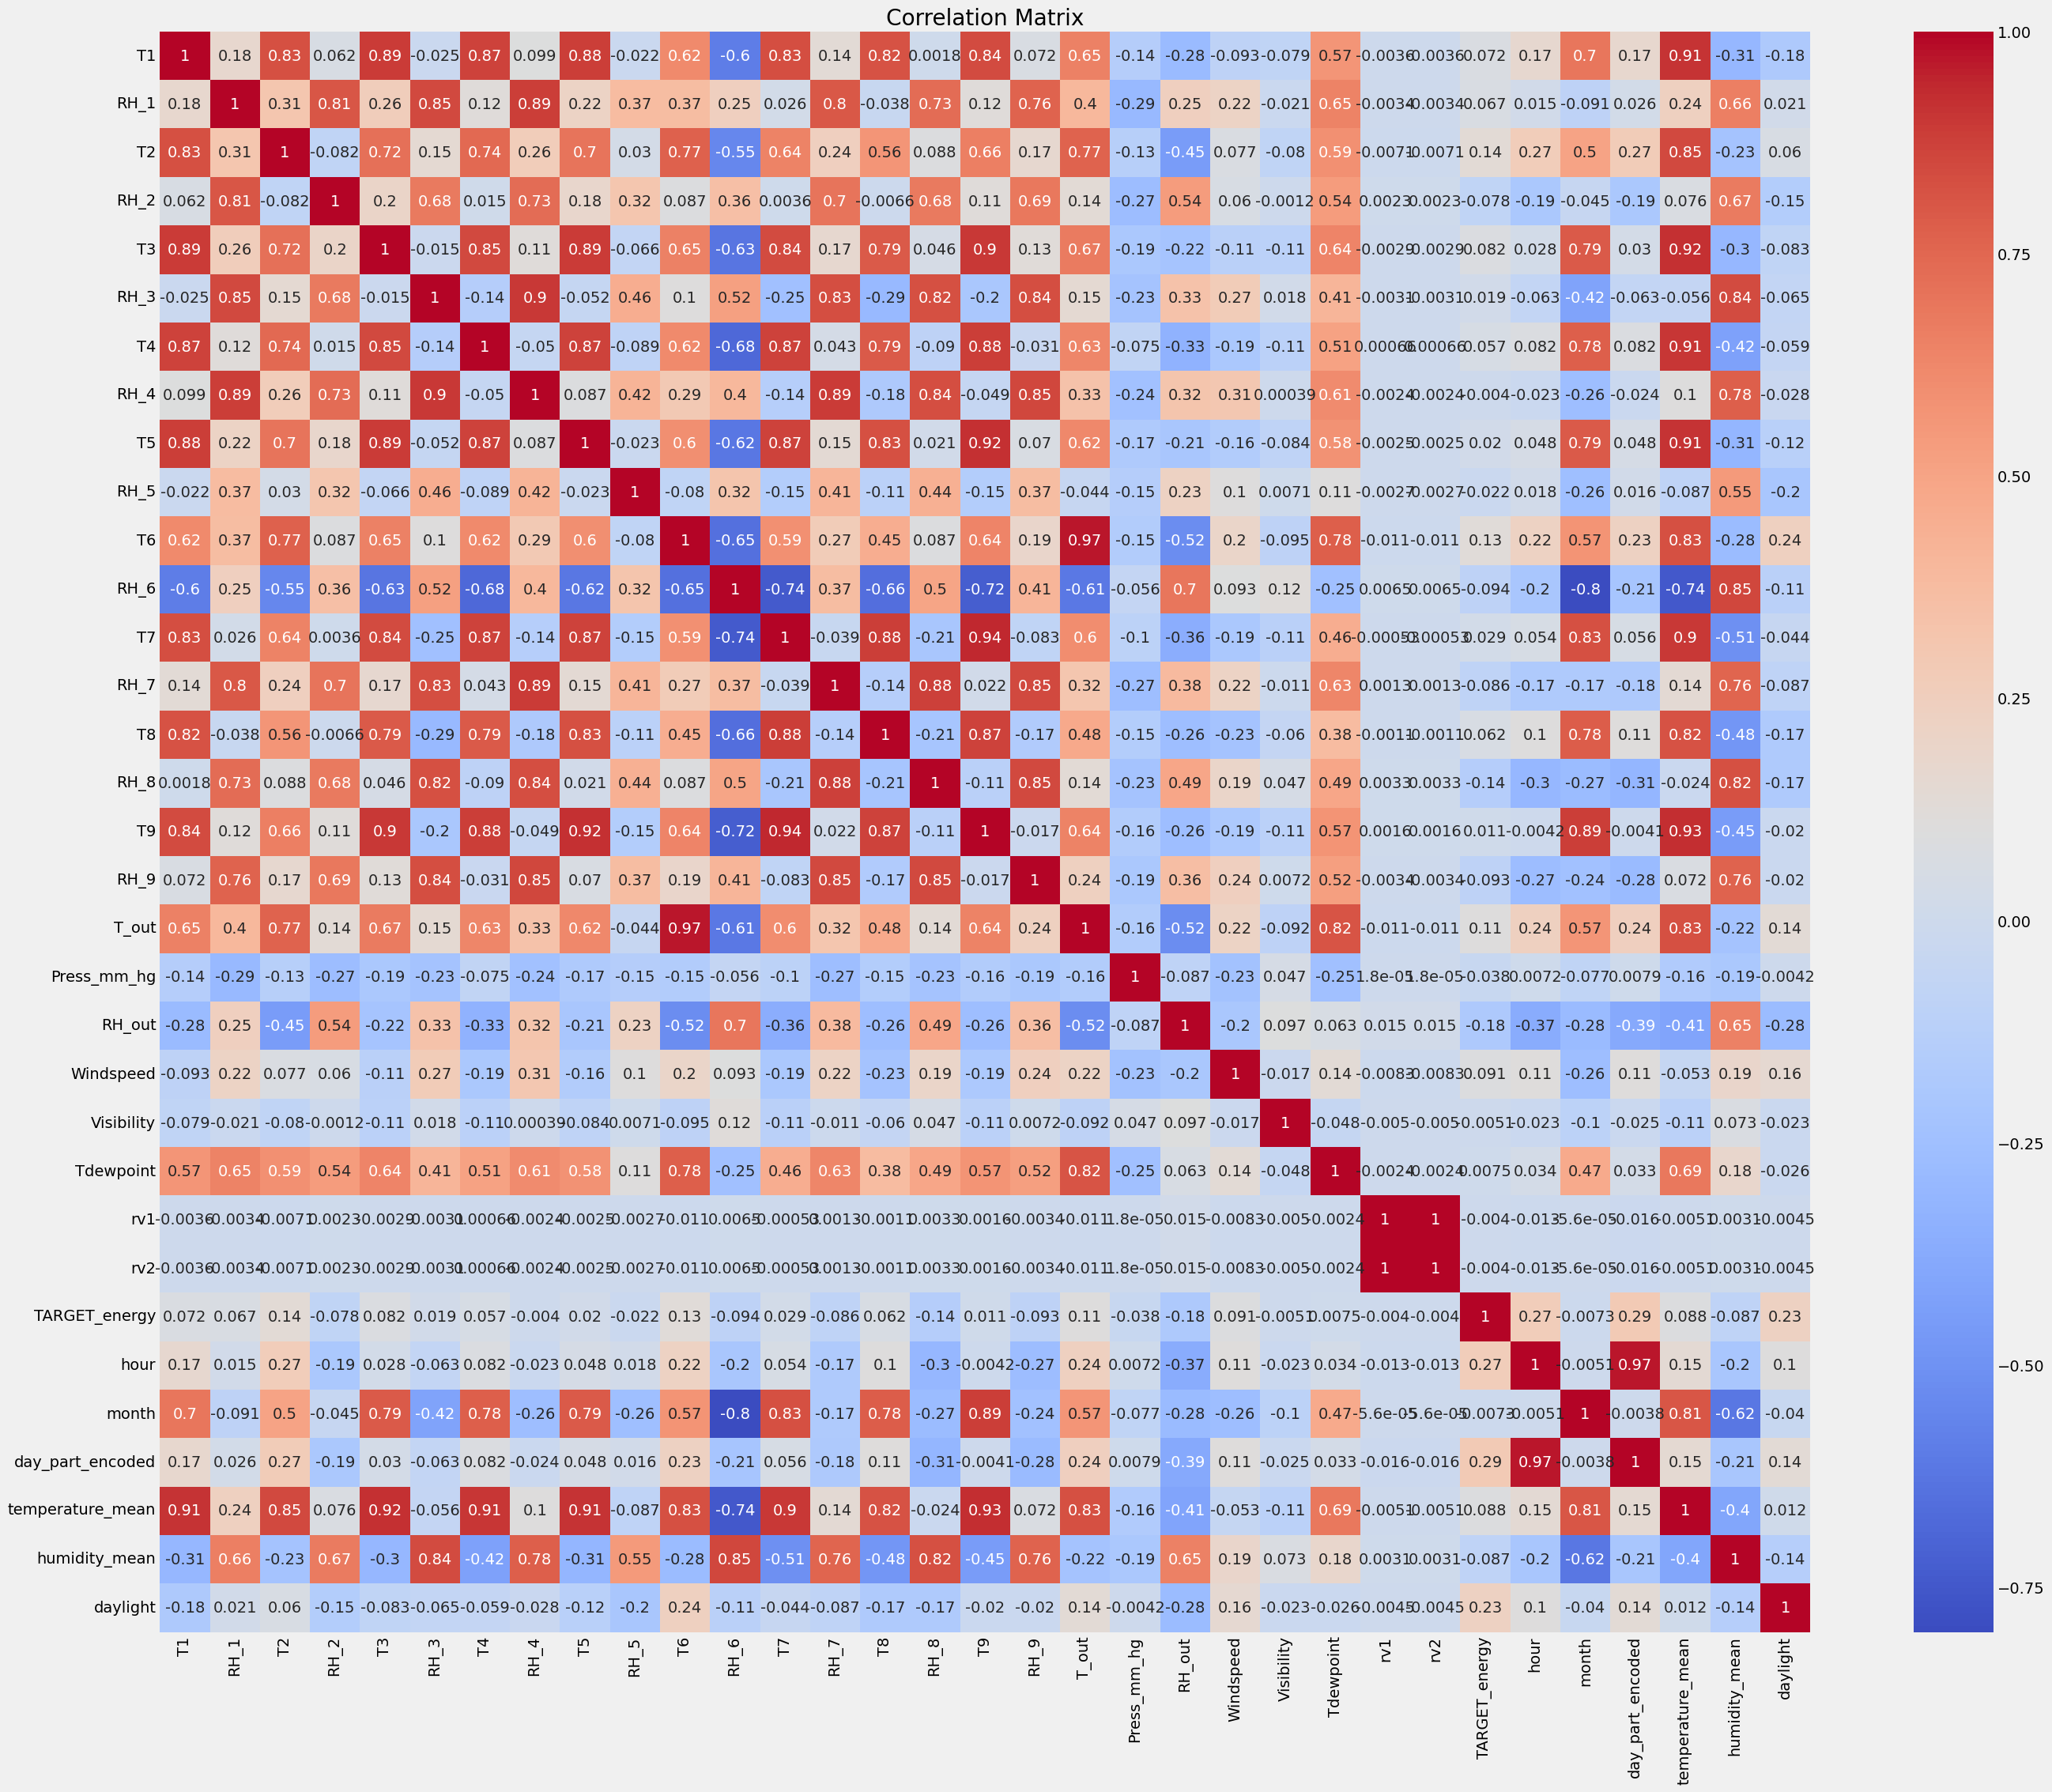

In [30]:
# Correlation Matrix
numeric_df_train = df_train_filtered.select_dtypes(include=[np.number])
plt.figure(figsize=(30, 25))
sns.heatmap(numeric_df_train.corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()